# ★★★ Three-Star Battery Data

This notebook demonstrates how to convert structured battery test data into a set of **open, machine-readable formats** that follow best practices for accessibility and interoperability. This corresponds to **three stars** in the Five-Star Battery Data framework.

---

## What does three-star mean?

In the 5-Star Battery Data framework, 3-star data is:
- Provided in an **open, non-proprietary file format** (e.g., `.csv`, `.json`, `.parquet`, `.hdf5`, `.txt`)
- **Machine-readable**, meaning it can be automatically parsed and processed by standard software tools
- **Not locked behind proprietary formats** (e.g., `.xlsx`, `.bin`, `.nda`) that require vendor-specific software

Using open formats is a critical step toward making data reusable, durable, and easy to work with across tools and platforms.

---

## Why is this important?

Battery test data is often stored in formats tied to specific vendors or applications. These formats are hard to parse, share, or archive. By saving your data in **open and well-supported formats**, you:
- Remove technical barriers to reuse
- Future-proof your dataset
- Enable smooth integration with analysis, modeling, and AI pipelines

---

## What is an open data format?

An open format is a file format that is:
- **Publicly documented** and widely supported
- **Accessible by open-source and commercial tools**
- Easy to parse using standard programming languages (Python, R, MATLAB, etc.)

Examples of open formats commonly used in battery data:
| Format    | Type        | Best For                                 |
|-----------|-------------|-------------------------------------------|
| `.csv`    | Tabular     | Simple time series, readable by humans    |
| `.json`   | Hierarchical| Metadata, structured nested data          |
| `.parquet`| Tabular     | Large datasets, compressed and efficient  |
| `.hdf5`   | Hierarchical| Scientific arrays, high-performance access|
| `.txt`    | Unstructured| Raw logs or device output                 |

---

## What we will do

In this notebook, we assume you have already processed your raw data into a **structured, BDF-compliant DataFrame** in the previous step.

We will:
1. **Load** the structured DataFrame from memory or file
2. **Serialize** it into multiple open, machine-readable formats:
   - `.txt`
   - `.json`
   - `.parquet`
   - `.hdf5`
3. **Compare** the resulting file sizes
4. **Demonstrate** how to re-load each format in Python

This notebook gives you a clear and reproducible workflow for sharing your structured battery data in formats that are **open, portable, and future-ready**.


## 1. Read the raw cycler data

We begin by reading the exported CSV file that contains the raw test data from the battery cycler. This file serves as the source for generating open, portable formats. It typically includes columns such as time, voltage, current, and temperature, depending on the cycler and configuration.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pyarrow
import json
import time

# Load raw CSV data
file_name = 'structured_battery_data.bdf.csv'
data = pd.read_csv(file_name)
data.head()

,Test Time / s,Current / A,Voltage / V,Unix Time / s,Step Count / 1,Temperature 1 / °C,Temperature 2 / °C,Temperature 3 / °C
0,0.00,0.0,3.8022,1.729688e+09,1,26.2,26.2,26.4
1,0.01,0.0,3.8022,1.729688e+09,1,26.2,26.2,26.4
2,10.00,0.0,3.8022,1.729688e+09,1,26.2,26.2,26.4
3,20.00,0.0,3.8022,1.729688e+09,1,26.2,26.2,26.4
4,30.00,0.0,3.8022,1.729688e+09,1,26.0,26.2,26.4


We can also visualize the data to verify the content and quality.

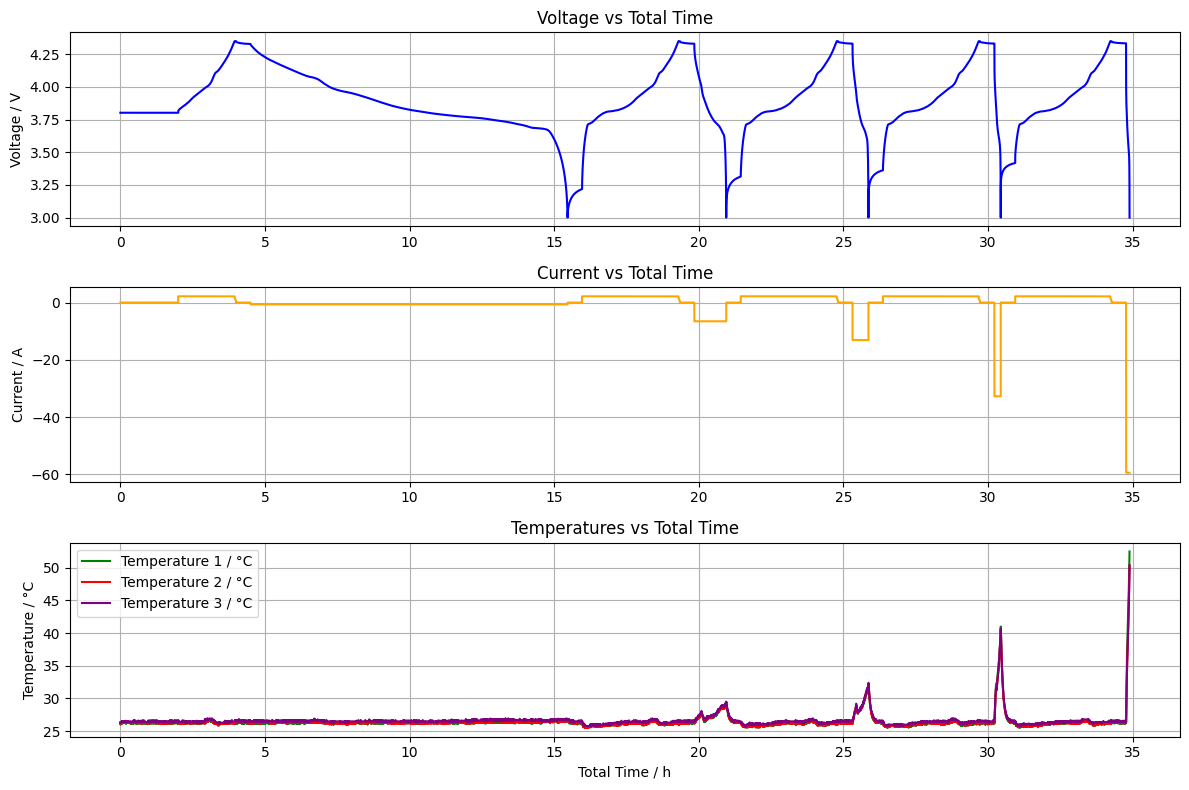

In [2]:
# Plot Voltage, Current, and all Temperatures vs Total Time in one figure
time_h = data['Test Time / s'] / 3600

plt.figure(figsize=(12, 8))

# Voltage
plt.subplot(3, 1, 1)
plt.plot(time_h, data['Voltage / V'], label='Voltage / V', color='blue')
plt.ylabel('Voltage / V')
plt.title('Voltage vs Total Time')
plt.grid(True)

# Current
plt.subplot(3, 1, 2)
plt.plot(time_h, data['Current / A'], label='Current / A', color='orange')
plt.ylabel('Current / A')
plt.title('Current vs Total Time')
plt.grid(True)

# Temperatures (1, 2, 3)
plt.subplot(3, 1, 3)
plt.plot(time_h, data['Temperature 1 / °C'], label='Temperature 1 / °C', color='green')
plt.plot(time_h, data['Temperature 2 / °C'], label='Temperature 2 / °C', color='red')
plt.plot(time_h, data['Temperature 3 / °C'], label='Temperature 3 / °C', color='purple')
plt.xlabel('Total Time / h')
plt.ylabel('Temperature / °C')
plt.title('Temperatures vs Total Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 2. Serialize the data into multiple open, machine-readable formats

After loading the raw data, we convert it into several widely used open formats: TXT, JSON, Parquet, and HDF5. Each format has different strengths in terms of size, readability, and performance. This step ensures the data can be shared and reused in diverse environments without relying on proprietary software.

In [3]:
# Save as .txt (tab-separated)
txt_path = file_name.replace('.csv', '.txt')
data.to_csv(txt_path, sep='\t', index=False)

# Save as .parquet
parquet_path = file_name.replace('.csv', '.parquet')
data.to_parquet(parquet_path, index=False)

# Save as .hdf5
hdf5_path = file_name.replace('.csv', '.h5')
data.to_hdf(hdf5_path, key='battery_data', mode='w')

# Save as .json
json_path = file_name.replace('.csv', '.json')
json_dict = {col: data[col].tolist() for col in data.columns}
with open(json_path, 'w') as f:
    json.dump(json_dict, f, indent=4)



## 3. Compare the resulting file sizes

Different file formats can vary significantly in storage efficiency. In this step, we compare the size of each serialized file to highlight how format choice affects disk usage—especially important for large datasets or when sharing data online.

In [4]:
formats = ['.parquet', '.csv', '.txt',  '.h5', '.json']
for ext in formats:
    path = file_name.replace('.csv', ext)
    size_kb = os.path.getsize(path) / 1024
    print(f'{ext.upper():>8}: {size_kb:.1f} KB')

.PARQUET: 255.2 KB
    .CSV: 689.0 KB
    .TXT: 689.0 KB
     .H5: 929.0 KB
   .JSON: 1698.6 KB


This comparison shows that the `.parquet` format produces the **smallest file size**—in this case, **less than half the size** of the original `.csv` file. Text-based formats like `.csv` and `.txt` are similar in size, since they both store uncompressed, human-readable data. 

Interestingly, `.h5` (HDF5) and `.json` result in **significantly larger files**, even though they contain the same DataFrame without additional metadata. This is due to differences in how each format encodes data internally. HDF5 includes structural overhead for hierarchical data storage, while JSON is a verbose text format with redundant field names. 

Parquet, by contrast, uses efficient binary encoding and compresses data by default—making it ideal for compact storage of structured tables.

## 4. Demonstrate and Compare Load Times Across Formats

To ensure that the data remains accessible and usable across tools, we show how to load each of the exported formats using standard Python libraries. This demonstrates the practical value of using open formats—data can be read reliably without relying on vendor-specific software.

In addition to demonstrating how each format can be loaded, we also **benchmark and compare the load times** to highlight the performance trade-offs between different open formats. This helps inform decisions about which format to use depending on the size of the dataset, speed requirements, and tool compatibility.


In [5]:
import pandas as pd
import timeit

# Define loaders as lambdas
loaders = {
    "CSV": lambda: pd.read_csv(file_name),
    "TXT": lambda: pd.read_csv(txt_path, sep="\t"),
    "PARQUET": lambda: pd.read_parquet(parquet_path),
    "HDF5": lambda: pd.read_hdf(hdf5_path, key='battery_data'),
    "JSON": lambda: pd.read_json(json_path)
}

# Benchmark each loader over multiple runs
read_times = {}
N = 10  # number of trials

for fmt, loader in loaders.items():
    t = timeit.timeit(loader, number=N)
    read_times[fmt] = t / N  # average time per run

# Sort and display
print(f"Average File Read Time over {N} runs (seconds):")
for fmt, t in sorted(read_times.items(), key=lambda x: x[1]):
    print(f"{fmt:8}: {t:.4f} s")


Average File Read Time over 10 runs (seconds):
TXT     : 0.0122 s
CSV     : 0.0158 s
HDF5    : 0.0179 s
JSON    : 0.0254 s
PARQUET : 0.1037 s


## Summary

In this notebook, you learned how to satisfy the requirements for **3-star battery data** by converting a structured dataset into multiple **open, machine-readable formats**.

| Step                  | What You Did                                                               |
|-----------------------|----------------------------------------------------------------------------|
| Start with structured data | Used the BDF-aligned dataset created in the 2-star notebook             |
| Serialize to formats  | Saved the data as `.txt`, `.json`, `.parquet`, and `.hdf5`                 |
| Compare file sizes    | Observed trade-offs between human-readability and compression efficiency   |
| Load in Python        | Demonstrated how to re-import each format using standard Python libraries  |

By following this workflow, your dataset is now:
- Available in **open, non-proprietary formats**
- Easily parsed by tools and programming languages
- Ready for long-term reuse and platform-independent sharing

This sets the stage for **semantic metadata (4-star)** and **linked data integration (5-star)**.


---

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b7/Flag_of_Europe.svg" alt="EU Flag" width="100"/>

**This work has received funding from the European Union under the Horizon Europe programme.**  
Views and opinions expressed are however those of the author(s) only and do not necessarily reflect those of the European Union or the European Commission. Neither the European Union nor the granting authority can be held responsible for them.